## RAG localy

Система RAG (Retrieval-Augmented Generation, генерация с использованием поиска) представляет собой новый подход, который сочетает сильные стороны больших языковых моделей (LLM) с возможностями информационного поиска для генерации более точных и информативных ответов. В традиционной схеме LLM модель полагается исключительно на свою внутреннюю базу знаний для генерации текста на основе заданного запроса или входных данных. Однако это может привести к ограничениям в плане способности модели доступа и включения внешних знаний, особенно для редких или специализированных тем.  
ниже картиночка которая все объясняет:

![alt text](f1.png "Title")

In [1]:
# all i neeeed 
import os
import torch
import pandas as pd
import fitz
import numpy as np 
import nltk
import re
import faiss
import textwrap

from spacy.lang.en import English
from sentence_transformers import SentenceTransformer,util
from tqdm.auto import tqdm

C:\Users\Kirilll\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


#### Collect pdf

In [2]:
# для good work  лучше создать папку 'pdf' и закинуть туда файлы 
def pdf_files():
    current_dir_os = os.getcwd() 
    pdf_dir=current_dir_os+'\\'+'pdf'
    return pdf_dir

def get_file(pdf_dir):
    files_path=[]
    files = os.listdir(pdf_dir)
    for i in files:
        file_path=pdf_dir+'\\'+i
        files_path.append(file_path)
    return files_path
# условно получаем список из файлов ПДФ
# get_file(pdf_files())


#### Read PDF

In [3]:
def text_filter(text:str):
    # убираем переносы 
    clean_text=text.replace('\n',' ').strip()
    return clean_text

def open_pdf(path:str) ->list[dict]:
    doc=fitz.open(path)
    pageXtext=[]
    for pg_number,page in tqdm(enumerate(doc)):
        page_text=page.get_text()
        #  фильтруем
        cleaned_text=text_filter(page_text)
		#  формируем список в соотвествии с требования 
        pageXtext.append({
            				'file_name': os.path.basename(path),
            				'page_number':pg_number-14, # в моем случае было лучше 14 (тк с 14 начинается текст ток)
                           	'page_char_count':len(cleaned_text),
                           	'page_word_count':len(cleaned_text.split(' ')),
                           	'page_sentence_count':len(cleaned_text.split('. ')),
                           	'page_tokens_count': len(cleaned_text)/4,
                           	'text':cleaned_text,
                              }) 

    return pageXtext
# получаем список файлов 
path=get_file(pdf_files())
# выбираем файл
page_and_text=open_pdf(path[1])

0it [00:00, ?it/s]

#### Remove data to pandas

In [4]:
Data=pd.DataFrame(page_and_text)
Data.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_tokens_count
count,114.00,114.00,114.00,114.00,114.00
mean,42.50,954.70,165.00,17.04,238.68
std,33.05,463.97,84.13,35.63,115.99
min,-14.00,20.00,5.00,1.00,5.00
25%,14.25,615.75,110.50,6.00,153.94
50%,42.50,1073.50,176.50,10.00,268.38
75%,70.75,1324.25,227.75,13.75,331.06
max,99.00,1619.00,362.00,242.00,404.75


Дальнейшая обработка текста (разбиение страниц на предложения)
Идеальный способ обработки текста перед его встраиванием vẫn является активной областью исследований.

Простой метод, который я нашел полезным, заключается в разбиении текста на части, состоящие из предложений.

То есть, разбить страницу текста на группы по 5, 7, 10 или более предложений (эти значения не являются фиксированными и могут быть изучены).

#### Preprocessing...

In [5]:
# --- spacy
nlp=English()
# Construction like add_pipe
sentencizer = nlp.add_pipe("sentencizer")

for item in tqdm(page_and_text):
    item['sentence']=list(nlp(item['text']).sents)
    # приводим все к единому формату
    item['sentence']=[str(sentence) for sentence in item['sentence']]
    item['sentence_count']=len(item['sentence'])

# # --- nltk (если захочется перейти и для обшего развития ) не отличается выходом
# for item in tqdm(page_and_text):
#     item['sentence'] = nltk.sent_tokenize(item['text'])  
#     item['sentence']=[str(sentence) for sentence in item['sentence']]
#     item['sentence_count']=len(item['sentence'])

  0%|          | 0/114 [00:00<?, ?it/s]

#### Make chunking

In [6]:
# Выбираем сколько предложений будет входить в отрывок и делим основной текст на эти 
sent_chunk_size=7

def list_chunk(item,chunk_size):
    # сюда передаем список с предложениями и делим
    return [item[i:i+chunk_size] for i in range(0,len(item),chunk_size)]

def chunking_text(data,chunk_size):
        # разбиваем на опр кол-во предложений и составляем новые item
        for item in tqdm(data):
            item['sentence_chunk']=list_chunk(item['sentence'],chunk_size)

chunking_text(page_and_text,7)
        
# Теперь нужно сделать так , чтоб каждый кусок был отдельным айтемом
def chunking(data):
    page_and_chunk=[]
    for item in tqdm(data):
        for sentence in item['sentence_chunk']:
            chunk_dict={}
            chunk_dict['page_number']=item['page_number']

            join_sent_chunk=''.join(sentence).replace('  ',' ').strip()
            join_sent_chunk=re.sub(r"\.([A-Z])",r". \1",join_sent_chunk  )

            chunk_dict['sentence_chunk']=join_sent_chunk
            chunk_dict['word_count']=len([word for word in join_sent_chunk.split(' ')])
            chunk_dict['token_count']=int(len(join_sent_chunk)/4)

            page_and_chunk.append(chunk_dict)
    return page_and_chunk
    
page_and_chunk=chunking(page_and_text)

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

In [7]:
# можно варьировать минимальным количеством токенов
min_token_length=30
Data=pd.DataFrame(page_and_chunk)
# примеры меньше 30
for row in Data[Data['token_count']<min_token_length].sample(5).iterrows():
    print (row[1]['token_count'], row[1]['sentence_chunk'])

# непосредственно фильтруем данные
page_and_chunk_filtered=Data[Data['token_count']>min_token_length].to_dict(orient='records')
page_and_chunk_filtered[0]

23 Figure 3.8: Input image of the area target [49]. Figure 3.9: Intensity of the area target.48
3 IEEE, 2015.100
3 IEEE, 2017.97
22 In beamforming, the data collected by sensors are processed by weight vector to form a 67
29 ARRAY SIGNAL PROCESSING FOR SYNTHETIC APERTURE RADAR (SAR) THESIS BY QIFENG LIU DECEMBER 2018 UNIVERSITY OF SHEFFIELD


{'page_number': -13,
 'sentence_chunk': 'Array Signal Processing for Synthetic Aperture Radar(SAR) by Qifeng Liu B. Eng A master thesis submitted in partial fulﬁlment of the requirements for the award of Master of Philosophy Supervisors: Dr. Wei Liu and Dr. Xiaoli Chu December 2018',
 'word_count': 39,
 'token_count': 60}

#### Embeddings

In [8]:
# выбираем модель для формирования эмбеддинга
model_name='sentence-transformers/all-MiniLM-L12-v2'
embd_model=SentenceTransformer(model_name_or_path=model_name,
                               device='cuda')

# можно так
for item in tqdm(page_and_chunk_filtered):
    item['embedding']=embd_model.encode(item['sentence_chunk'])
    
# можно и вот так
# text_chunk=[item['sentence_chunk'] for item in page_and_chunk_filtered]
# text_chunk_embedings=embd_model.encode(text_chunk,
#                                        batch_size=8,
#                                        convert_to_tensor=True)

  0%|          | 0/190 [00:00<?, ?it/s]

C:\Users\Kirilll\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


#### Save embeddings as file

In [ ]:
page_and_chunk_embeddings=pd.DataFrame(page_and_chunk_filtered)
page_and_chunk_embeddings.to_csv('page_and_chunk_embeddings.csv',index=False)

,page_number,sentence_chunk,word_count,token_count,embedding
0,-13,Array Signal Processing for Synthetic Aperture...,39,60,[ 3.94535661e-02 -2.01664343e-02 -6.65103421e-...


#### RAG search and answer

In [10]:
device='cuda' if torch.cuda.is_available() else 'cpu'

load_embeddings=pd.read_csv('page_and_chunk_embeddings.csv')
# convert embedding to array
load_embeddings['embedding']=load_embeddings['embedding'].apply(lambda x:np.fromstring(x.strip('[]'),sep=' '))
# convert to tensor
embedding=torch.Tensor(np.stack(load_embeddings['embedding'].to_list(),axis=0))

# to list of dict
page_and_chunks=load_embeddings.to_dict(orient='records')
# page_and_chunks[0]

#### Semantic search pipline

In [11]:
# это самый простой поиск на основе embedding (просто ищем то что ближе через метрику)
from sentence_transformers import util
# 1 задаем вопрос
query="The relationship of time and frequency of the LFM signal"
print (f'Query - {query}')
# 2 подгружаем ембд 
query_embedding=embd_model.encode(query, convert_to_tensor=True).to(device)
# 3 ищем ближайшие с помощью 
dot_scores=util.dot_score(a=query_embedding,b=embedding.to(device))
# 4 выводим ближайшие результаты (топ 5)
top_results_dot_prod=torch.topk(dot_scores,k=5)
top_results_dot_prod

Query - The relationship of time and frequency of the LFM signal


torch.return_types.topk(
values=tensor([[0.6631, 0.6011, 0.5978, 0.5764, 0.5611]], device='cuda:0'),
indices=tensor([[44, 46, 51, 84, 90]], device='cuda:0'))

#### FAISS

1) Эффективный поиск подобных векторов: FAISS позволяет быстро искать подобные векторы в больших наборах данных, что может быть полезно для задач, таких как поиск похожих текстов или предложений в большом корпусе текстов.  
2) Оптимизация поиска: FAISS использует различные алгоритмы и структуры данных для оптимизации поиска подобных векторов, что может уменьшить время поиска и улучшить производительность системы.  
3) Масштабируемость: FAISS может обрабатывать большие наборы данных и может быть использован в распределенных системах, что делает его подходящим для крупномасштабных приложений LLM.  

In [12]:
# 1 определяем датасет на основе эмбеддингов
database = pd.DataFrame(embedding.cpu().numpy())
# 2 инициализируем векторную БД
index = faiss.IndexFlatL2(database.shape[1])
# 3 Часто мы будем использовать индексы, которые требуют от нас обучения их нашим данным перед использованием 
index.is_trained
# 4 затем мы добавляем новые векторы, используя метод add.
index.add(database)

In [13]:
# ищем топ 3 похожих 
k = 3
query = embd_model.encode(["What is LFM ?"])

D, I = index.search(query, k)  # search
print(I)

[[44 46 90]]


In [14]:
# Теперь, если мы предпочитаем извлечь числовые векторы из FAISS, мы тоже можем это сделать.
vecs = np.zeros((k, database.shape[1]))
for i, val in enumerate(I[0].tolist()):
    vecs[i, :] = index.reconstruct(val)

Добавление секционирования в индекс
FAISS позволяет нам добавить дополнительный шаг для оптимизации эффективности поиска, используя множество различных методов. Популярный подход — разбиение индекса на ячейки Вороного. Используя этот метод, мы возьмем вектор запроса, определим ячейку, которой он принадлежит,
а затем используйте наш IndexFlatL2 для поиска между вектором запроса и всеми индексированными векторами, принадлежащими этой ячейке. Мы также можем включить векторы из других близлежащих клеток.

Мы инициализируем наш новый секционированный индекс, сначала добавляя нашу предыдущую операцию IndexFlatL2 в качестве шага квантования (еще один шаг в процессе поиска).
и передать это в новую операцию IndexIVFFlat следующим образом:

In [15]:
nlist = 10
quantizer = faiss.IndexFlatL2(database.shape[1])
index = faiss.IndexIVFFlat(quantizer, database.shape[1], nlist)

Здесь мы добавили новый параметр nlist. Мы используем nlist, чтобы определить, сколько разделов мы хотим иметь в нашем индексе.

Когда мы создавали предыдущий индекс только для IndexFlatL2, мы отметили, что никакого обучения не требуется, поскольку для построения этого индекса не требуется никакой группировки/преобразования. Теперь, когда мы добавили секционирование с помощью IndexIVFFlat, это уже не так.
Давайте посмотрим на атрибут is_trained.

In [16]:
index.train(database)
index.is_trained
index.add(database)

In [17]:
%%time
k = 3
query = embd_model.encode(["What is LFM ?"])

D, I = index.search(query, k)  # search
print(I)

[[46 90 47]]
CPU times: total: 15.6 ms
Wall time: 26 ms


Мы также можем увеличить количество близлежащих ячеек для поиска с помощью nprobe.

In [18]:
%%time
index.nprobe = 10
D, I = index.search(query, k)  # search
print(I)

[[44 46 90]]
CPU times: total: 0 ns
Wall time: 999 µs


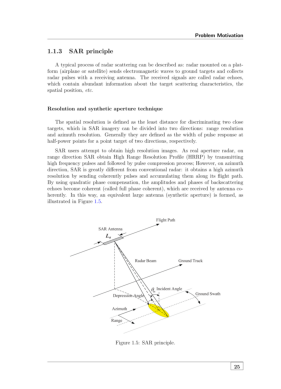

In [20]:
import fitz
# можно вывести самыую релевантную страницу
doc=fitz.open(path[0])
page=doc.load_page(11+14)

img=page.get_pixmap(dpi=400)
img.save('book.png')
doc.close()

img_array=np.frombuffer(img.samples_mv,
                        dtype=np.uint8).reshape(img.h,img.w,img.n)
import matplotlib.pyplot as plt
plt.imshow(img_array)
plt.axis('off')
plt.show()

#### Similarity measures

Точечное произведение 
- Мера величины и направления между двумя векторами
- Векторы, выровненные по направлению и величине, имеют более высокое положительное значение
- Векторы, противоположные по направлению и величине, имеют более высокое отрицательное значение torch.dot, np.dot, sentence_transformers.util.dot_score  

Косинусоидальное сходство - Векторы нормализуются по величине / евклидовой норме) / норме L2, поэтому они имеют единичную длину и сравниваются в большей степени по направлению
- Векторы, выровненные по направлению, имеют значение, близкое к 1
- Векторы, противоположные по направлению, имеют значение, близкое к -1

In [39]:
def dot_prod(vec1,vec2):
    return torch.dot(vec1,vec2)

def cisine_similarity(vec1,vec2):
    dot_product=torch.dot(vec1,vec2)
    norm1=torch.sqrt(torch.sum(vec1))
    norm2=torch.sqrt(torch.sum(vec2))
    return dot_product/(norm1*norm2)

#### Functionizing semantic search pipline

In [40]:
def relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embd_model,
                                n_resources_to_return: int=5,):

    query_embedding = model.encode(query, convert_to_tensor=True) 

    dot_scores = util.dot_score(query_embedding, embeddings.to(device))[0]

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)
    print (scores)
    return scores, indices

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

# пример 
# r=relevant_resources('The relationship of time and frequency of the LFM signal',embedding)


In [43]:

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict],
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")
        
print_top_results_and_scores('The relationship of time and frequency of the LFM signal',
                             embedding,
                             page_and_chunks,
                             3)


tensor([0.6631, 0.6011, 0.5978], device='cuda:0')
Query: The relationship of time and frequency of the LFM signal

Results:
Score: 0.6631
2.1.3 SAR Signal Properties In SAR, linear frequency modulated(LFM) signal, which is also
called chirp signal, is used for pulse compression. The properties of LFM signal will be
introduced ﬁrstly. LFM signal is a kind of modulated signals in which the frequency
increases or decreases with time. [39]. The relationship of time and frequency of the LFM
signal is a linear function. The mathematical equation can be expressed as s(t) = rect  t
T0  exp j2πfct + jπKt2    (2.9) where t is the time variable in seconds, T0 is time
duration of the LFM signal, fc is carrier frequency and K is the linear FM rate in Hz/s.
The instantaneous frequency is the derivative of phase and can be expressed as f = 1 2π
dφ(t) dt = 1 2π d(2πfct + πKt2) dt = fc + Kt (2.10) This means that the frequency is a
linear function of time t with the slope K. The waveform of LFM signa

In [24]:
# gpu memory 
gpu_bt=torch.cuda.get_device_properties(0).total_memory
gpu_gb=round(gpu_bt/(2**30))
print (gpu_gb)

4


#### Identify model

In [25]:
# flash attention 2 
import torch
from transformers.utils import is_flash_attn_2_available 
from transformers import BitsAndBytesConfig,AutoModelForCausalLM, AutoTokenizer
# from ctransformers import AutoModelForCausalLM # https://github.com/marella/ctransformers?tab=readme-ov-file#transformers

quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)
# Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa" # scale dot production
print(f"[INFO] Using attention implementation: {attn_implementation}")

[INFO] Using attention implementation: sdpa


In [26]:
# инитим модель
model_name = "Qwen/Qwen2.5-1.5B-Instruct"
# model_name = "Qwen/Qwen2.5-0.5B-Instruct"
# начинаем с претрена все тренировочки и токенизатор
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="cuda",
    attn_implementation=attn_implementation,
    quantization_config=quantization_config
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [27]:
similar_texts = [page_and_chunk[i]["sentence_chunk"] for i in I[0]]

In [28]:
# запрос
prompt = "Give me a short introduction to LFM signal"

combined_text = f"Promt: {prompt}\nSimilarity text:\n" + "\n".join(similar_texts)
# inputs = tokenizer(combined_text, return_tensors='pt', padding=True, truncation=True)
# Создайте шаблон приглашения для модели, настроенной на основе инструкций
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": combined_text}
]
# Примените шаблон чата
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False, # keep as raw text (not tokenized)
    add_generation_prompt=True
)
# Наш следующий шаг - выделить этот форматированный текст и передать его методу generate() нашей модели.
# Мы позаботимся о том, чтобы наш токенизированный текст был на том же устройстве, что и наша модель (GPU), используя "to("cuda")".
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

# Генерировать выходные данные, передаваемые по токенизированному входу
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=128
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [31]:
print (response)

### Introduction to LFM Signal

#### 2.1.2 Geometric Model of SAR

This section aims to describe a general data acquisition geometric model for Synthetic Aperture Radar (SAR) and defines some geometry-related terms. **Figure 2.3** illustrates a general model of a SAR concerning radar location and its beam footprint illuminated on the Earth's surface.

A SAR generates images in slant range (not ground range) and azimuth coordinates. The intersection of the zero Doppler plane with the ground is referred to as the zero Doppler line. The squint angle \ in the figure represents an angle between the antenna beam


Excellent! Now let's test our functions out.


## Application of the written RAG LLM

In [ ]:
# работает , если проверить , то в исходном нужно закоментить лишнее
from pred_train import PDF_analyze as pdf
from pred_train import Text_preprocessing as tp
from pred_train import Text_filter
from pred_train import Make_embedding
from pred_train import Vector_base
from pred_train import Response_system

PDF=pdf("pdf",'help_info.json')
ls=PDF.pdf_dir()
path=PDF.filepath_list(ls)
# page_and_text=PDF.read_file(path[0])  
# print(page_and_text)
books_text=PDF.processed_pdf(path)

TP=tp(books_text,7)
TP.text2sentence()
TP.sentence2chunk()
chunked=TP.chunking()
print (chunked[0])
# print(books_text[5])

res=Text_filter.token_filter(chunked,30)

In [ ]:

model_name='sentence-transformers/all-MiniLM-L12-v2'
embedding_model=Make_embedding(res,model_name)

embedding=embedding_model.embedding_process()

nlist=10
query='The relationship of time and frequency of the LFM signal'
database_name='Radio_book.index'

VB=Vector_base(embedding,nlist)
database=VB.base_formation()
VB.save_vector_base(database,database_name)
# подгружаем векторную базу данных
dist,idx=VB.search_bd(embedding_model.model(),database_name,query,10,3)
print (idx[0])
# print (res[423]['sentence_chunk'])

In [ ]:
llm_name="Qwen/Qwen2.5-1.5B-Instruct"
promt=query

RS=Response_system(res,idx)
LLM_model,LLM_tokenizer=RS.llm_model(llm_name)
response=RS.make_response(promt,LLM_tokenizer,LLM_model,)

print (response)